In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pickle

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn.metrics import plot_confusion_matrix, confusion_matrix

from imblearn.pipeline import Pipeline as imbPipeline

%matplotlib inline
plt.style.use('fivethirtyeight')

In [2]:
df_values = pd.read_csv('Data/Nepal_Earthquake_train_values.csv', index_col='building_id')
df_labels = pd.read_csv('Data/Nepal_Earthquake_train_labels.csv', index_col='building_id')

### Merge the values dataframe with the labels dataframe

In [3]:
df = df_values.join(df_labels)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 260601 entries, 802906 to 747594
Data columns (total 39 columns):
 #   Column                                  Non-Null Count   Dtype 
---  ------                                  --------------   ----- 
 0   geo_level_1_id                          260601 non-null  int64 
 1   geo_level_2_id                          260601 non-null  int64 
 2   geo_level_3_id                          260601 non-null  int64 
 3   count_floors_pre_eq                     260601 non-null  int64 
 4   age                                     260601 non-null  int64 
 5   area_percentage                         260601 non-null  int64 
 6   height_percentage                       260601 non-null  int64 
 7   land_surface_condition                  260601 non-null  object
 8   foundation_type                         260601 non-null  object
 9   roof_type                               260601 non-null  object
 10  ground_floor_type                       260601 non-

There are 260,601 records and 38 features (plus the target, 'damage_grade') in the dataset.

### Target Distribution

In [5]:
df['damage_label'] = df.damage_grade.map(
    {1:'Low Damage', 2:'Medium Damage', 3:'Complete Destruction'})

In [6]:
df.damage_label.value_counts(normalize=True)

Medium Damage           0.568912
Complete Destruction    0.334680
Low Damage              0.096408
Name: damage_label, dtype: float64

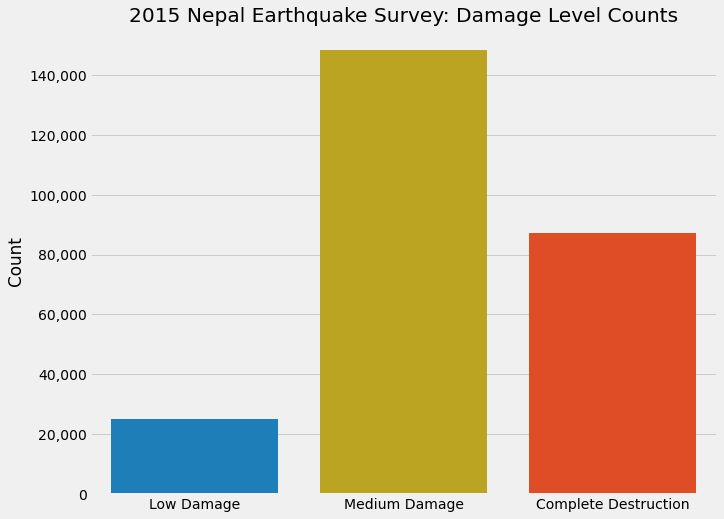

In [7]:
palette = {'Low Damage' : 'xkcd:cerulean', 
           'Medium Damage': 'xkcd:dark yellow',
           'Complete Destruction': 'xkcd:red orange'}
fig, ax = plt.subplots(figsize=(10,8))
ax = sns.countplot(x='damage_label', data=df, palette=palette, 
                   order=['Low Damage', 'Medium Damage', 'Complete Destruction'])
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
ax.set_xlabel('')
ax.set_ylabel('Count')
ax.set_title('2015 Nepal Earthquake Survey: Damage Level Counts');

There is a target imbalance:  low damage = 9.7%, medium damage = 56.9%, and complete detruction = 33.5%.  I will have to decide later whether to use any resampling techniques.

### Create column categories

Divide the columns for easier analysis.

In [8]:
binary_cols = []
for col in df.columns:
    if col.startswith('has'):
        binary_cols.append(col)

cat_cols = list(df.select_dtypes(include='object').columns)
cat_cols.remove('damage_label')

integer_cols = ['count_floors_pre_eq', 'age', 'area_percentage', 'height_percentage', 'count_families']

geo_cols = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id']

all_cols = geo_cols + cat_cols + integer_cols + binary_cols

In [9]:
len(all_cols)

38

### Categorical Columns

There are eight categorical columns, with a total of 38 possibles values across all eight columns.

In [10]:
n_unique = 0
for col in cat_cols:
    n_unique += df[col].nunique()
    print(f"There are {df[col].nunique()} unique values in the feature '{col}'.")
    print(f"The values are {df[col].unique()}")
    print("--------------------------------")
print(f'There are {n_unique} total categorical values in the categorical columns.')

There are 3 unique values in the feature 'land_surface_condition'.
The values are ['t' 'o' 'n']
--------------------------------
There are 5 unique values in the feature 'foundation_type'.
The values are ['r' 'w' 'i' 'u' 'h']
--------------------------------
There are 3 unique values in the feature 'roof_type'.
The values are ['n' 'q' 'x']
--------------------------------
There are 5 unique values in the feature 'ground_floor_type'.
The values are ['f' 'x' 'v' 'z' 'm']
--------------------------------
There are 4 unique values in the feature 'other_floor_type'.
The values are ['q' 'x' 'j' 's']
--------------------------------
There are 4 unique values in the feature 'position'.
The values are ['t' 's' 'j' 'o']
--------------------------------
There are 10 unique values in the feature 'plan_configuration'.
The values are ['d' 'u' 's' 'q' 'm' 'c' 'a' 'n' 'f' 'o']
--------------------------------
There are 4 unique values in the feature 'legal_ownership_status'.
The values are ['v' 'a' 'r

### Binary Columns

There are 22 binary (or 'flag') columns that use a 1 to designate that a building has that feature, or else a 0.  The binary columns are divided into 'has_superstructure' and 'has_secondary_use' characteristics. 

In [11]:
len(binary_cols)

22

Let's plot the average value for each binary column to get a sense of how frequently these features are flagged '1'.

<ipython-input-12-21fa6e00ad8f>:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(mean_binary_cols.index), rotation=90)


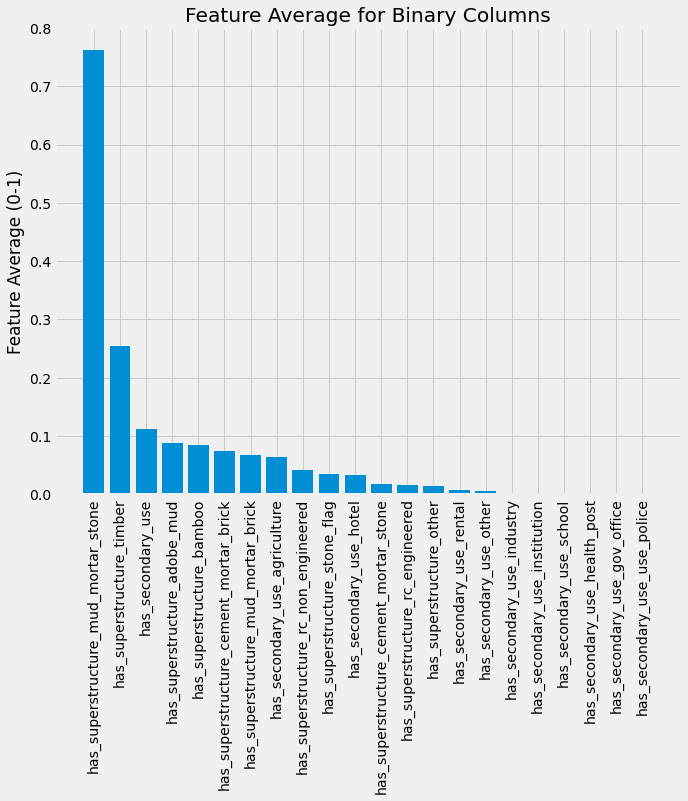

In [12]:
mean_binary_cols = df[binary_cols].mean().sort_values(ascending=False)
fig, ax = plt.subplots(figsize=(10,8))
ax.bar(mean_binary_cols.index, mean_binary_cols.values)
ax.set_xticklabels(list(mean_binary_cols.index), rotation=90)
ax.set_ylabel('Feature Average (0-1)')
ax.set_title('Feature Average for Binary Columns');

All but three of the columns have average values less than .1, indicating that they occur unfrequently.  'has_superstructure_mud_mortar_stone', however, occurs more than 70% of the time.  

I will now plot the complete destruction percentage for the various superstructures.

In [13]:
superstructure_cols = [col for col in binary_cols if col.startswith('has_superstructure')]

In [14]:
superstructure_cols

['has_superstructure_adobe_mud',
 'has_superstructure_mud_mortar_stone',
 'has_superstructure_stone_flag',
 'has_superstructure_cement_mortar_stone',
 'has_superstructure_mud_mortar_brick',
 'has_superstructure_cement_mortar_brick',
 'has_superstructure_timber',
 'has_superstructure_bamboo',
 'has_superstructure_rc_non_engineered',
 'has_superstructure_rc_engineered',
 'has_superstructure_other']

In [15]:
df_superstructure = pd.DataFrame(columns=['superstructure', 'Low Damage', 'Medium Damage', 'Complete Destruction'])
count = 0
for col in superstructure_cols:
    df1 = df[df[col] == 1]
    num_1 = len(df1[df1['damage_grade'] == 1])
    num_2 = len(df1[df1['damage_grade'] == 2])
    num_3 = len(df1[df1['damage_grade'] == 3])
    df_superstructure.loc[count, 'superstructure'] = col
    df_superstructure.loc[count, 'Low Damage'] = num_1 / (num_1 + num_2 + num_3) * 100
    df_superstructure.loc[count, 'Medium Damage'] = num_2 / (num_1 + num_2 + num_3) * 100
    df_superstructure.loc[count, 'Complete Destruction'] = num_3 / (num_1 + num_2 + num_3) * 100
    count += 1

In [16]:
df_superstructure_sorted = df_superstructure.sort_values(by='Complete Destruction', ascending=False)
df_superstructure_sorted.reset_index(inplace=True)

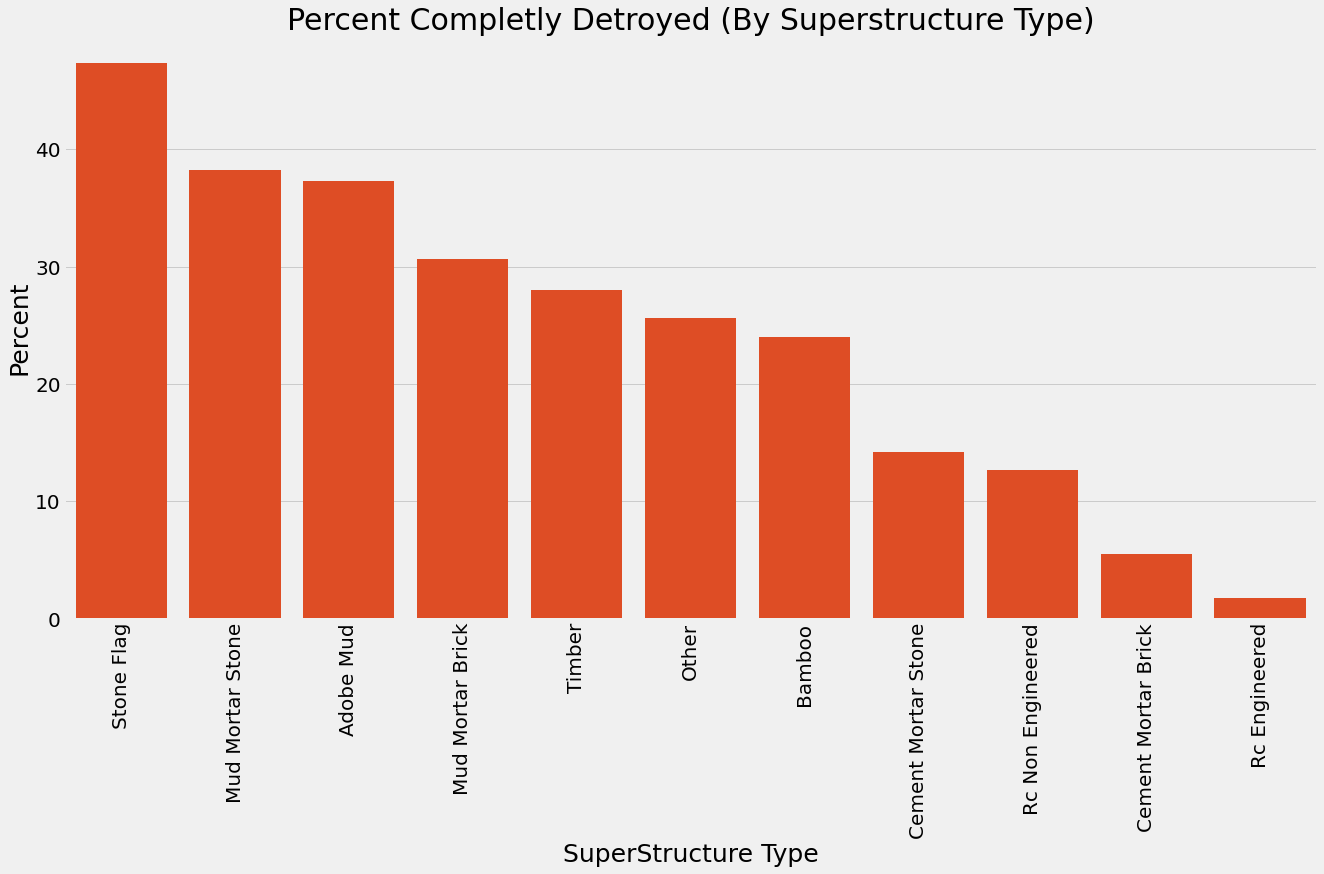

In [56]:
palette2 = {}
for var in list(df_superstructure_sorted.superstructure):
    palette2[var] = 'xkcd:red orange'
    
formatted_list = []
for i, superstructure in enumerate(list(df_superstructure_sorted.superstructure)):
    formatted_string = ' '.join(df_superstructure_sorted.superstructure[i].split('_')[2:]).title()
    formatted_list.append(formatted_string)
    
fig, ax = plt.subplots(figsize=(20,10))
sns.barplot(x='superstructure', y='Complete Destruction', data=df_superstructure_sorted, 
            palette=palette2, ax=ax)
ax.set_ylabel('Percent', fontsize=25)
plt.yticks(fontsize=20)
ax.set_xlabel('SuperStructure Type', fontsize=25)
ax.set_xticklabels(formatted_list, rotation=90, fontsize=20)
ax.set_title('Percent Completly Detroyed (By Superstructure Type)', fontsize=30);

Create similar plots for the 'has_secondary_use' binary columns.

In [18]:
secondary_cols = [col for col in binary_cols if col.startswith('has_secondary')]
secondary_cols.remove('has_secondary_use')

In [19]:
secondary_cols

['has_secondary_use_agriculture',
 'has_secondary_use_hotel',
 'has_secondary_use_rental',
 'has_secondary_use_institution',
 'has_secondary_use_school',
 'has_secondary_use_industry',
 'has_secondary_use_health_post',
 'has_secondary_use_gov_office',
 'has_secondary_use_use_police',
 'has_secondary_use_other']

In [20]:
df_secondary = pd.DataFrame(columns=['secondary_use', 'Low Damage', 'Medium Damage', 'Complete Destruction'])
count = 0
for col in secondary_cols:
    df1 = df[df[col] == 1]
    num_1 = len(df1[df1['damage_grade'] == 1])
    num_2 = len(df1[df1['damage_grade'] == 2])
    num_3 = len(df1[df1['damage_grade'] == 3])
    df_secondary.loc[count, 'secondary_use'] = col
    df_secondary.loc[count, 'Low Damage'] = num_1 / (num_1 + num_2 + num_3) * 100
    df_secondary.loc[count, 'Medium Damage'] = num_2 / (num_1 + num_2 + num_3) * 100
    df_secondary.loc[count, 'Complete Destruction'] = num_3 / (num_1 + num_2 + num_3) * 100
    count += 1

In [21]:
df_secondary_sorted = df_secondary.sort_values(by='Complete Destruction', ascending=False)
df_secondary_sorted.reset_index(inplace=True)

In [22]:
df_secondary_sorted

,index,secondary_use,Low Damage,Medium Damage,Complete Destruction
0,0,has_secondary_use_agriculture,4.94129,63.6526,31.4061
1,8,has_secondary_use_use_police,17.3913,52.1739,30.4348
2,5,has_secondary_use_industry,21.147,54.4803,24.3728
3,9,has_secondary_use_other,13.1184,63.8681,23.0135
4,4,has_secondary_use_school,31.9149,50,18.0851
5,1,has_secondary_use_hotel,25.2881,57.72,16.9919
6,7,has_secondary_use_gov_office,34.2105,55.2632,10.5263
7,6,has_secondary_use_health_post,24.4898,65.3061,10.2041
8,2,has_secondary_use_rental,41.5443,49.7868,8.66888
9,3,has_secondary_use_institution,40.4082,52.6531,6.93878


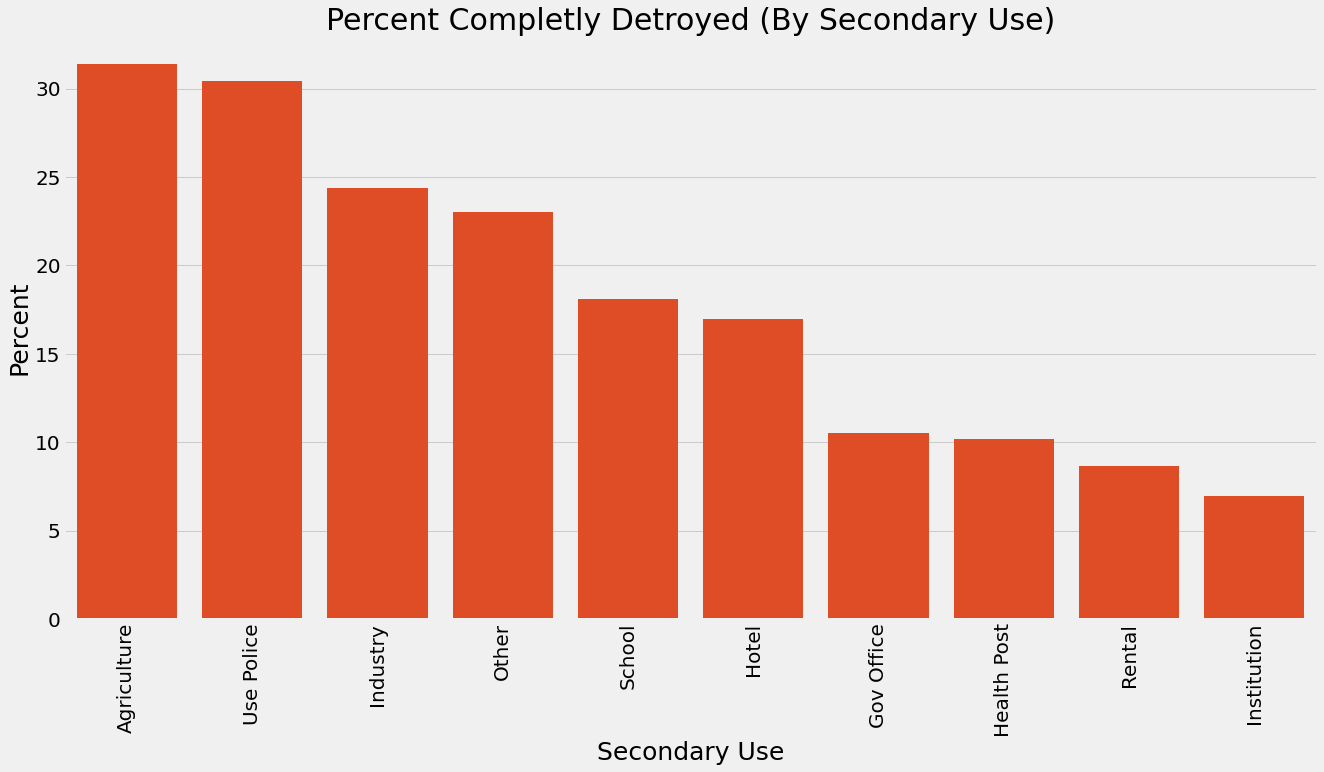

In [58]:
palette3 = {}
for var in list(df_secondary_sorted.secondary_use):
    palette3[var] = 'xkcd:red orange'
    
formatted_list = []
for i, secondary in enumerate(list(df_secondary_sorted.secondary_use)):
    formatted_string = ' '.join(df_secondary_sorted.secondary_use[i].split('_')[3:]).title()
    formatted_list.append(formatted_string)
    
fig, ax = plt.subplots(figsize=(20,10))
sns.barplot(x='secondary_use', y='Complete Destruction', data=df_secondary_sorted, 
            palette=palette3, ax=ax)
ax.set_ylabel('Percent', fontsize=25)
plt.yticks(fontsize=20)
ax.set_xlabel('Secondary Use', fontsize=25)
ax.set_xticklabels(formatted_list, rotation=90, fontsize=20)
ax.set_title('Percent Completly Detroyed (By Secondary Use)', fontsize=30);

### Integer Columns

There are five integer columns.  First, I'll inspect the distribution of each feature.

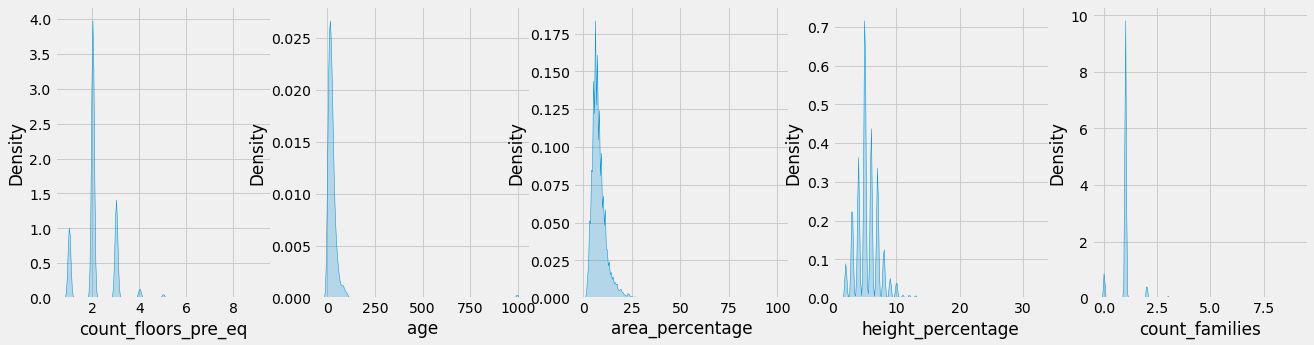

In [24]:
fig, axs = plt.subplots(1, 5, figsize=(20, 5))
for ax, col in zip(axs, integer_cols):
    sns.kdeplot(df[col], ax=ax, shade=True);

Now I'll plot the three damage levels by age of the building.

In [25]:
df_age = pd.DataFrame(columns=['age', 'Low Damage', 'Medium Damage', 'Complete Destruction'])
count = 0
for age in range(0,105,5):
    num_1 = 0
    num_2 = 0
    num_3 = 0
    df1 = df[(df.age == age) & (df.damage_grade == 1)]
    num_1 += len(df1)
    df2 = df[(df.age == age) & (df.damage_grade == 2)]
    num_2 += len(df2)
    df3 = df[(df.age == age) & (df.damage_grade == 3)]
    num_3 += len(df3)
    df_age.loc[count, 'age'] = age
    df_age.loc[count, 'Low Damage'] = num_1 / (num_1 + num_2 + num_3) * 100
    df_age.loc[count, 'Medium Damage'] = num_2 / (num_1 + num_2 + num_3) * 100
    df_age.loc[count, 'Complete Destruction'] = num_3 / (num_1 + num_2 + num_3) * 100
    count += 1

In [26]:
melt_df_age = df_age.melt(id_vars='age')
melt_df_age

,age,variable,value
0,0,Low Damage,27.6986
1,5,Low Damage,16.589
2,10,Low Damage,11.2094
3,15,Low Damage,7.99222
4,20,Low Damage,6.07172
...,...,...,...
58,80,Complete Destruction,41.5057
59,85,Complete Destruction,34.1204
60,90,Complete Destruction,35.8525
61,95,Complete Destruction,38.4058


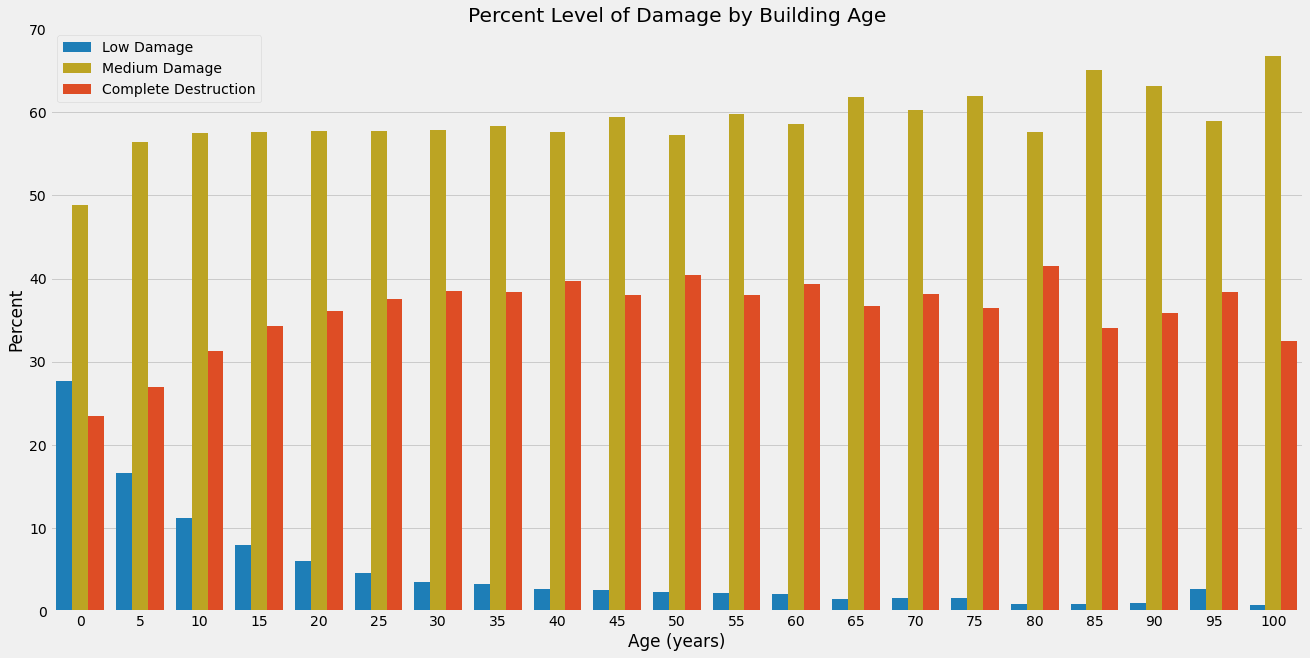

In [27]:
fig, ax = plt.subplots(figsize=(20,10))
sns.barplot(x='age', y='value', hue='variable', data=melt_df_age, palette=palette, ax=ax)
ax.set_ylabel('Percent')
ax.set_xlabel('Age (years)')
ax.set_title('Percent Level of Damage by Building Age')
ax.legend(title='');

Let's also plot damage levels by number of floors in the building.

In [28]:
df_floors = pd.DataFrame(columns=['floors', 'Low Damage', 'Medium Damage', 'Complete Destruction'])
count = 0
for floor in range(1,8,1):
    num_1 = 0
    num_2 = 0
    num_3 = 0
    df1 = df[(df.count_floors_pre_eq == floor) & (df.damage_grade == 1)]
    num_1 += len(df1)
    df2 = df[(df.count_floors_pre_eq == floor) & (df.damage_grade == 2)]
    num_2 += len(df2)
    df3 = df[(df.count_floors_pre_eq == floor) & (df.damage_grade == 3)]
    num_3 += len(df3)
    df_floors.loc[count, 'floors'] = floor
    df_floors.loc[count, 'Low Damage'] = num_1 / (num_1 + num_2 + num_3) * 100
    df_floors.loc[count, 'Medium Damage'] = num_2 / (num_1 + num_2 + num_3) * 100
    df_floors.loc[count, 'Complete Destruction'] = num_3 / (num_1 + num_2 + num_3) * 100
    count += 1

In [29]:
melt_df_floors = df_floors.melt(id_vars='floors')
melt_df_floors

,floors,variable,value
0,1,Low Damage,22.178
1,2,Low Damage,8.04033
2,3,Low Damage,4.56155
3,4,Low Damage,13.0347
4,5,Low Damage,11.309
5,6,Low Damage,25.3589
6,7,Low Damage,25.641
7,1,Medium Damage,51.428
8,2,Medium Damage,59.9963
9,3,Medium Damage,51.2056


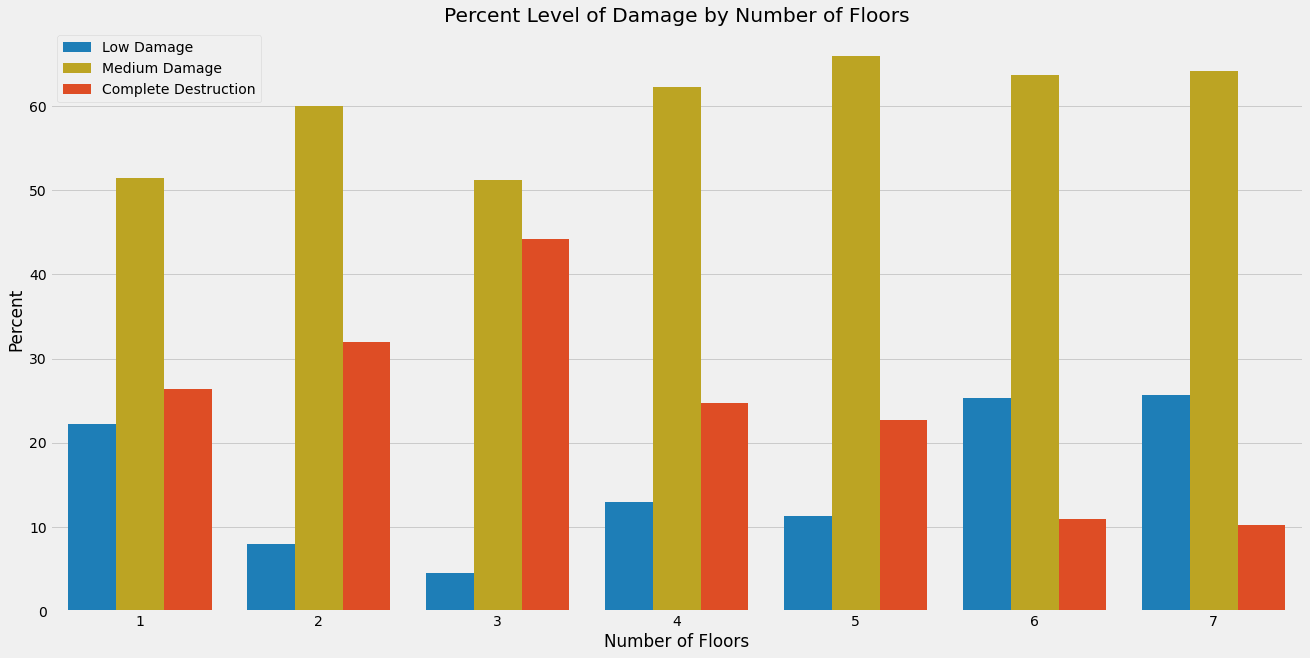

In [30]:
fig, ax = plt.subplots(figsize=(20,10))
sns.barplot(x='floors', y='value', hue='variable', data=melt_df_floors, palette=palette, ax=ax)
ax.set_ylabel('Percent')
ax.set_xlabel('Number of Floors')
ax.set_title('Percent Level of Damage by Number of Floors')
ax.legend(title='');

Since the features are severly right skewed, let's apply a log transformation and recheck the distributions. 

In [31]:
df_log = pd.DataFrame(index=df.index)
for col in integer_cols:
    df_log[f'log_{col}'] = df[col].apply(lambda x: np.log(x+1))

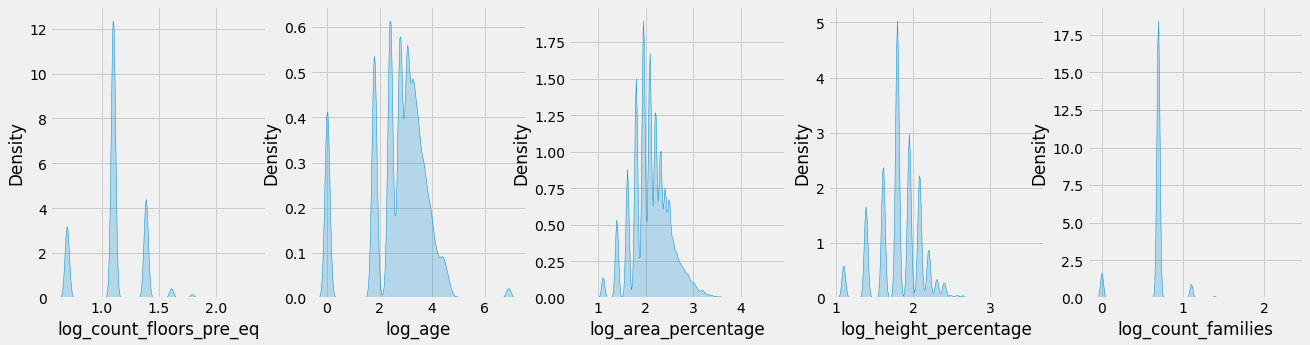

In [32]:
fig, axs = plt.subplots(1, 5, figsize=(20, 5))
for ax, col in zip(axs, df_log.columns):
    sns.kdeplot(df_log[col], ax=ax, shade=True);

The log transformation does remove much of the right skew.

### Geographical Columns

There are three geographical columns, 'geo_level_1_id', 'geo_level_2_id', and 'geo_level_3_id'.  Level 1 is the broadest category, with only 30 unique values, followed by level 2 with 1427, and level 3 with 12567.  We can assume that this means they represent descending levels of geographic range.  So level 1 could be on the order of a city, level 2 a neighborhood, and level 3 a street.  We aren't told what exactly they represent, but we at least surmise that they represent incresingly smaller geographical areas.  

In [33]:
for col in geo_cols:
    print(f'There are {df[col].nunique()} unique values in {col}.')
    print(f'The range of values is: {df[col].min()}, {df[col].max()}.')
    print('---------------------------------')

There are 31 unique values in geo_level_1_id.
The range of values is: 0, 30.
---------------------------------
There are 1414 unique values in geo_level_2_id.
The range of values is: 0, 1427.
---------------------------------
There are 11595 unique values in geo_level_3_id.
The range of values is: 0, 12567.
---------------------------------


### Correlations

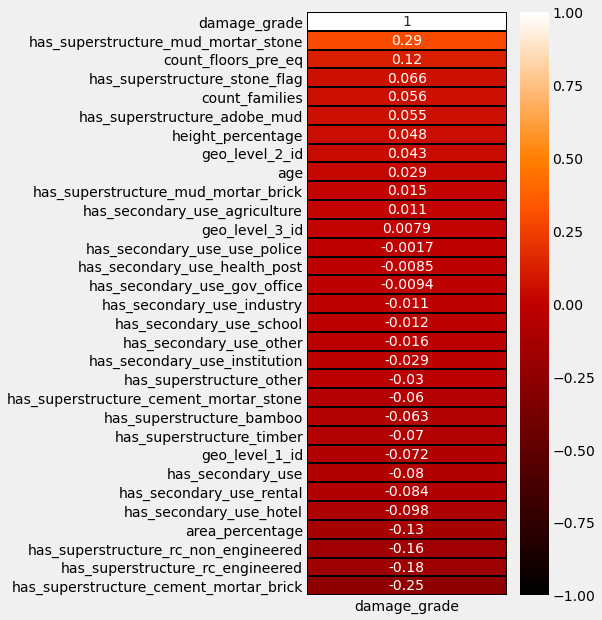

In [34]:
fig, ax = plt.subplots(figsize=(4,10))
sns.heatmap(df.corr()[['damage_grade']].sort_values(by='damage_grade', ascending=False),
           vmin=-1, vmax=1, linewidths=1, linecolor='black', annot=True, cmap="gist_heat");

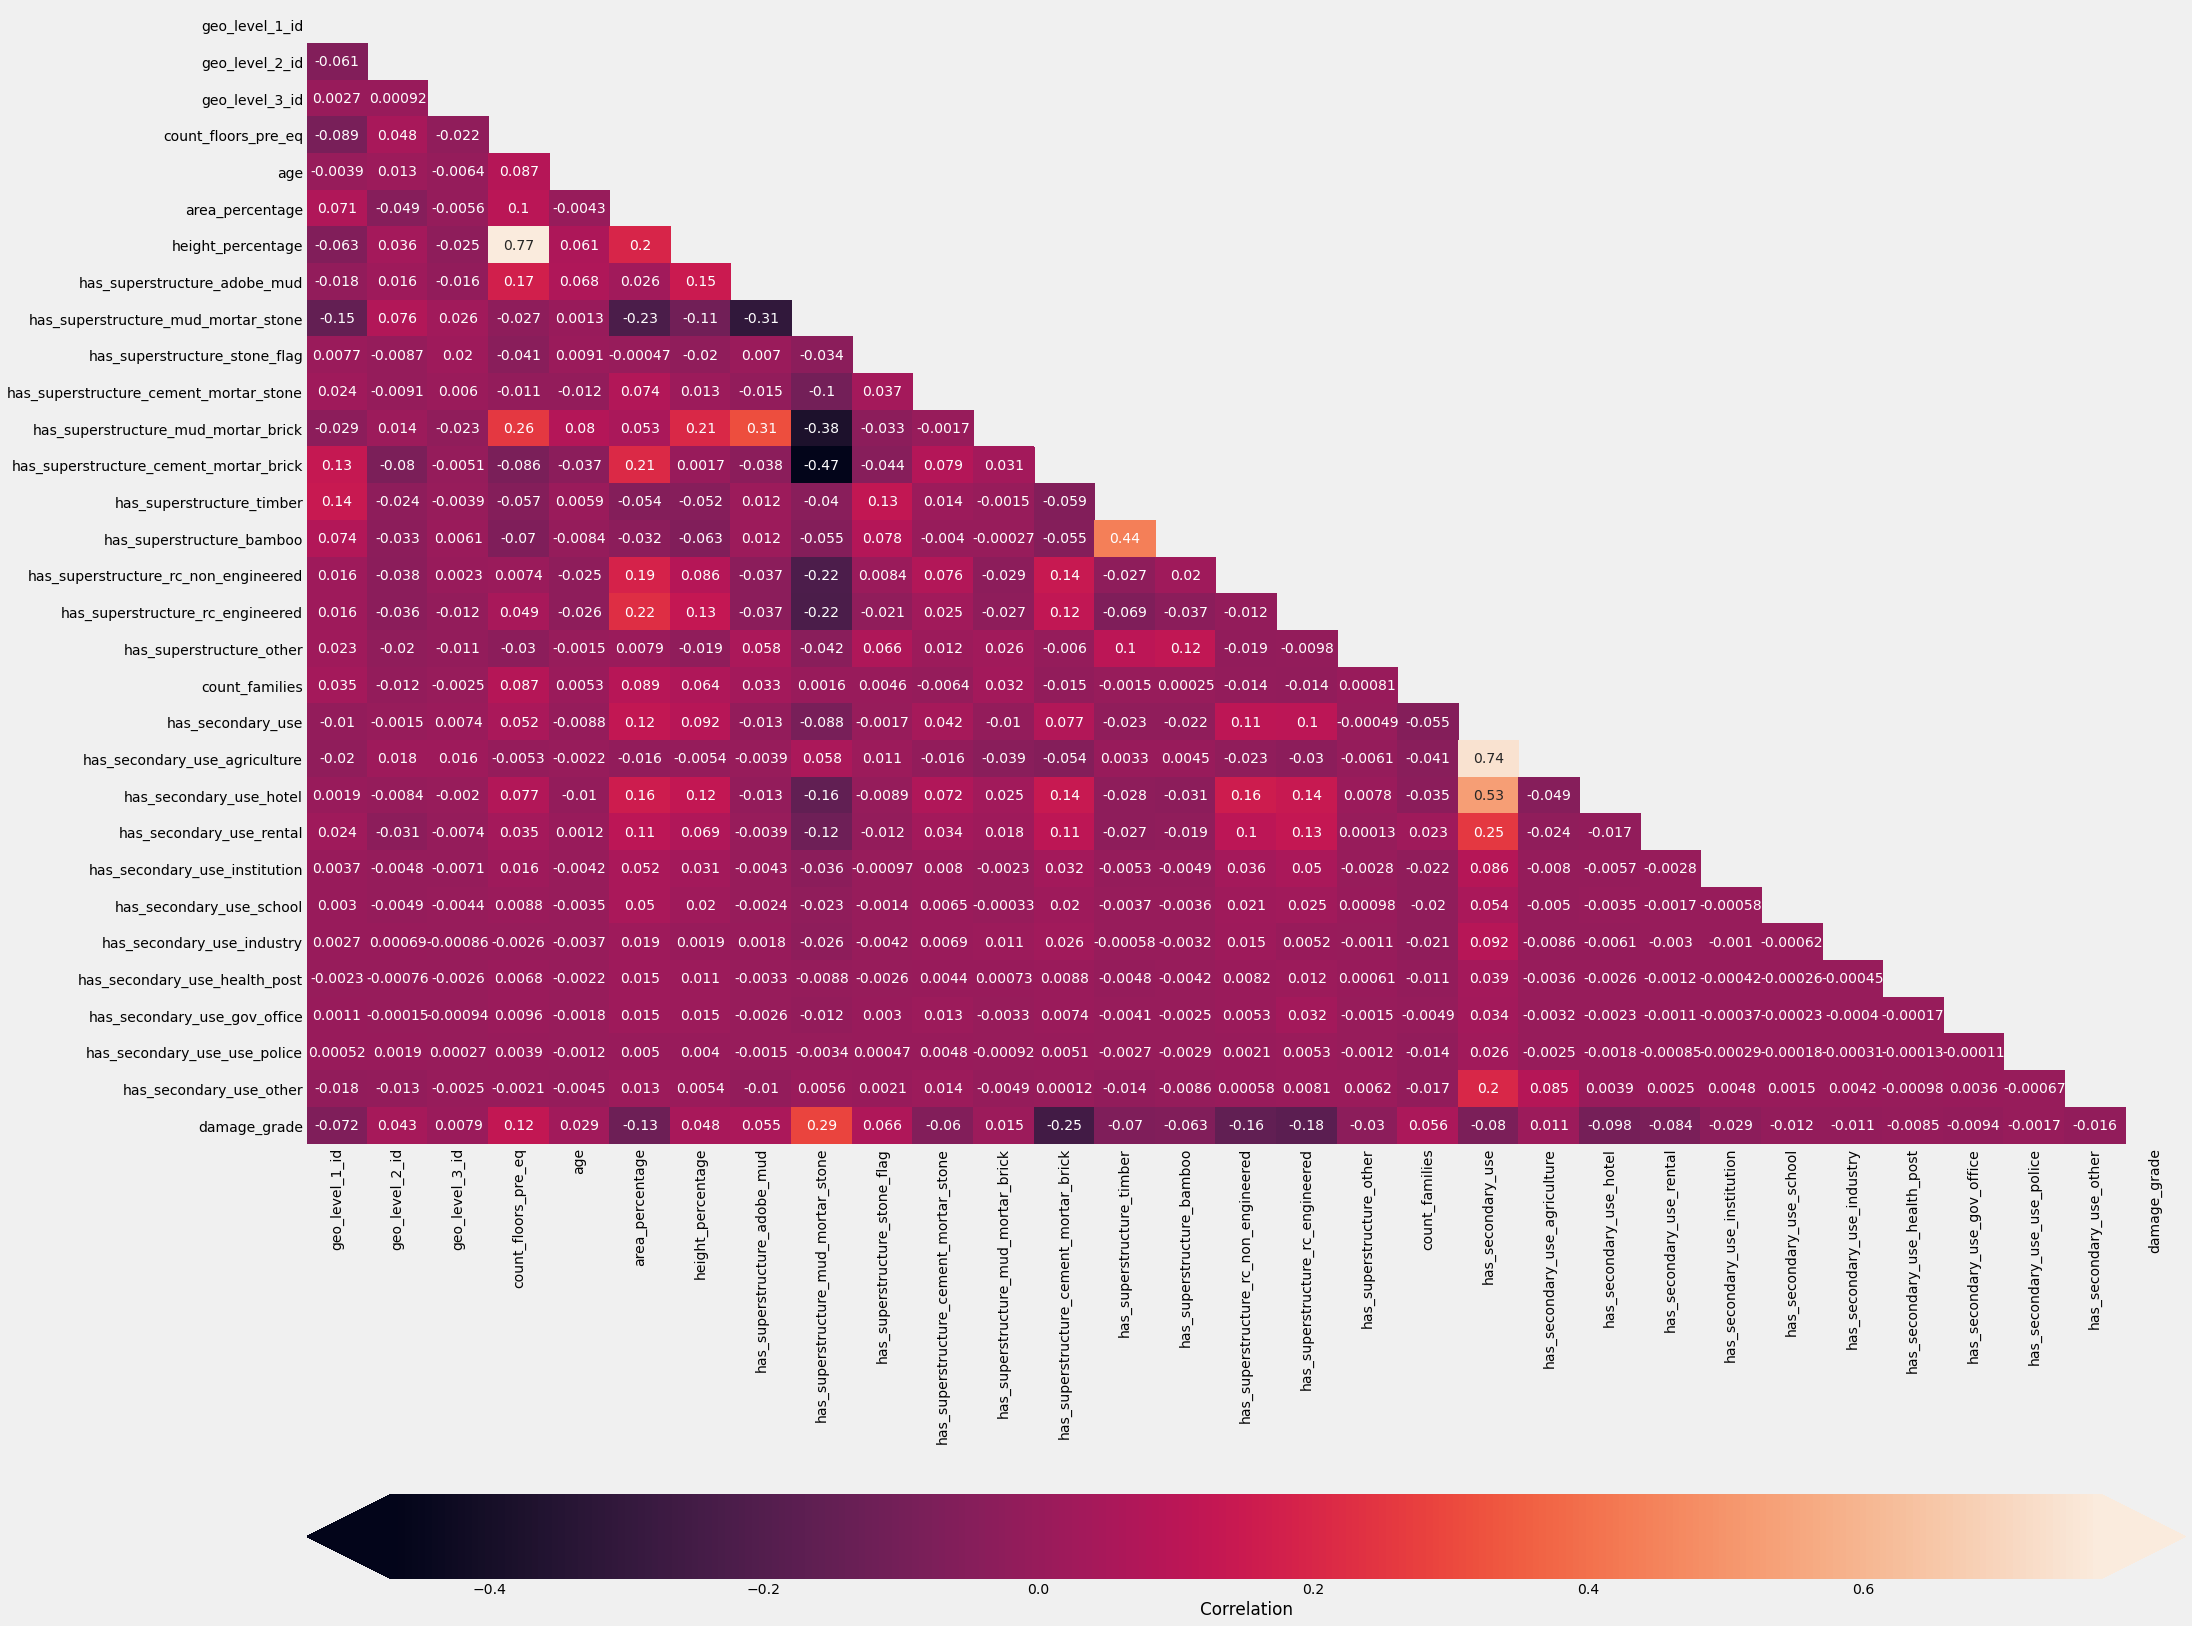

In [35]:
corr_matrix_mask = np.triu(np.ones_like(df.corr(), dtype=bool))
fig, ax = plt.subplots(figsize  =(30,30))
sns.heatmap(
            df.corr(), 
            ax=ax, 
            annot=True, 
            mask= corr_matrix_mask,
            cbar_kws={"label": "Correlation", "orientation": "horizontal", "pad": .2, "extend": "both"}
);

We should note that there are relatively weak correlations with the target.  The strongest correlations (either positive or negative) are less than .3. Let's run a baseline Random Forest model to check feature importances.

### Train Test Split

In [36]:
X = df.drop(['damage_grade', 'damage_label'], axis=1)
y = df.damage_grade

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [38]:
X_train.to_csv('Data/X_train.csv')
X_test.to_csv('Data/X_test.csv')
y_train.to_csv('Data/y_train.csv')
y_test.to_csv('Data/y_test.csv')

### Random Forest without feature engineering to check feature importances

In [39]:
dummy_X_train = pd.get_dummies(X_train)

In [40]:
baseline_forest = RandomForestClassifier(random_state=42)
baseline_forest.fit(dummy_X_train, y_train)

RandomForestClassifier(random_state=42)

In [41]:
with open ('../Models/baseline_forest.pickle', 'wb') as f:
    pickle.dump(baseline_forest, f, pickle.HIGHEST_PROTOCOL)

In [42]:
f1_micro = cross_val_score(baseline_forest, dummy_X_train, y_train, scoring='f1_micro')

In [43]:
f1_micro = f1_micro.mean()
f1_micro

0.7097876694806856

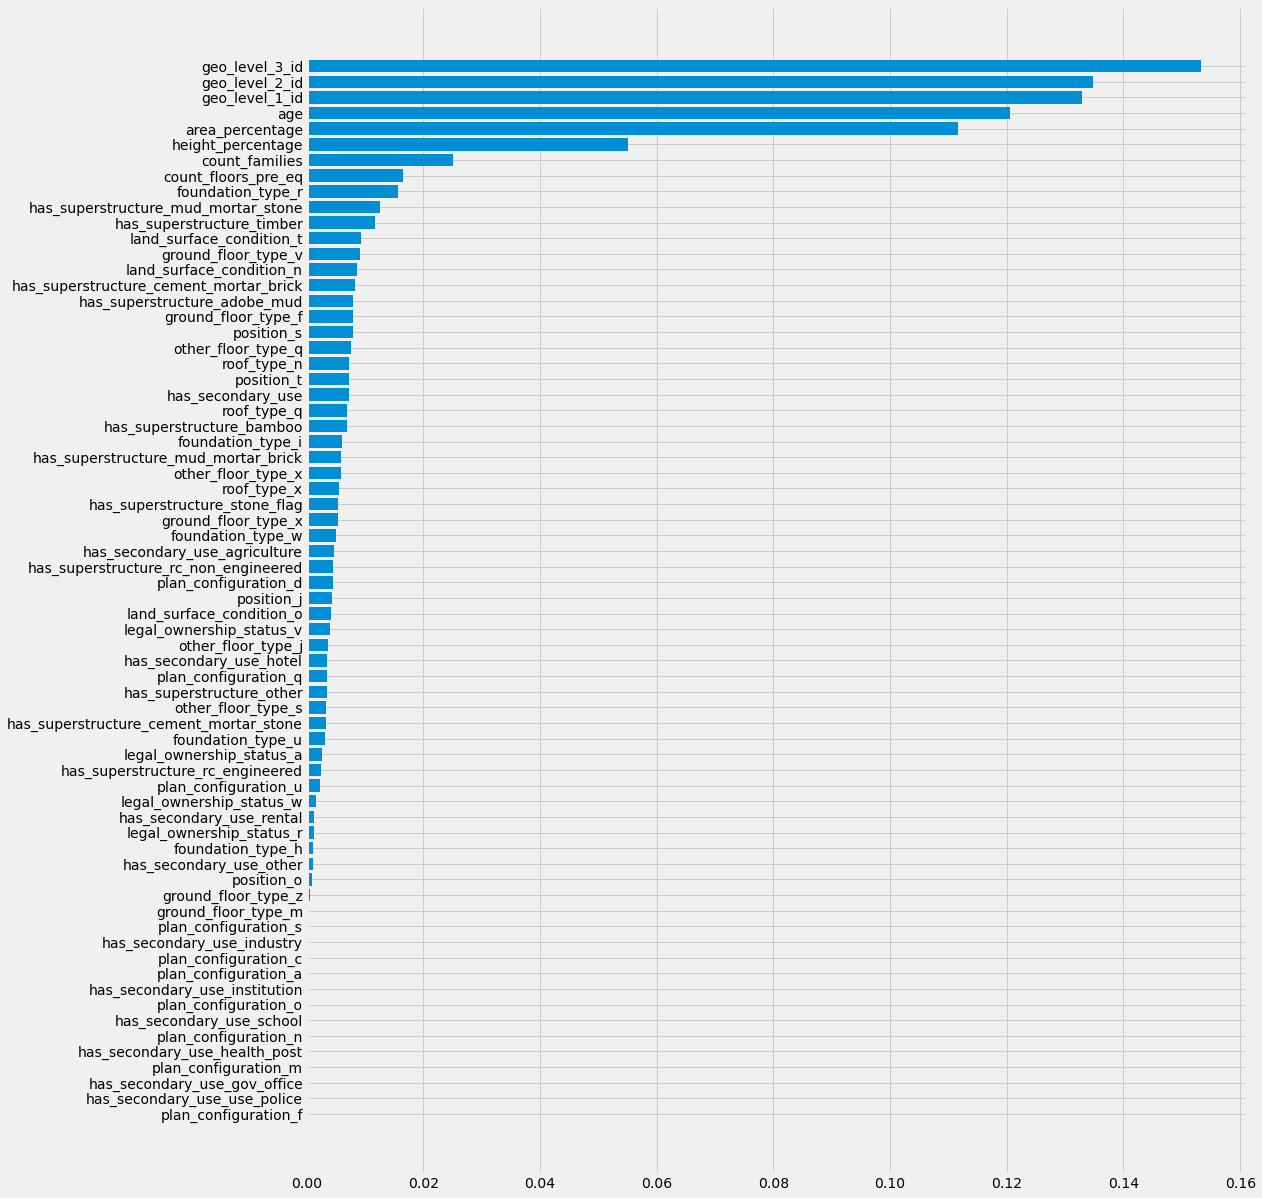

In [44]:
feat_importance = pd.DataFrame(baseline_forest.feature_importances_, 
                               columns=['Importance'], index=dummy_X_train.columns)
feat_importance_sorted = feat_importance.sort_values(by='Importance', ascending=True)
fig, ax = plt.subplots(figsize=(15,20))
ax.barh(feat_importance_sorted.index, feat_importance_sorted.Importance);

In [45]:
len(feat_importance)

68

After creating dummies for the categorical features, there are 68 columns.  Considering the low importance of many of the features, we should be able to drop some of them to simplify the models and improve run times.

### Dummy Model

In [46]:
dummy_model = DummyClassifier(strategy='most_frequent', random_state=42)
dummy_model.fit(X_train, y_train)

DummyClassifier(random_state=42, strategy='most_frequent')

In [47]:
f1_micro_dummy = cross_val_score(dummy_model, X_train, y_train, scoring='f1_micro')

In [48]:
f1_micro_dummy = f1_micro_dummy.mean()
f1_micro_dummy

0.5689127654131492

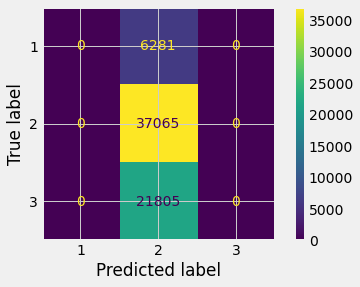

In [51]:
plot_confusion_matrix(dummy_model, X_test, y_test);

In [50]:
y_pred = dummy_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
low_damage = cm[0][0] / (cm[0][0] + cm[0][1] + cm[0][2])
medium_damage = cm[1][1] / (cm[1][0] + cm[1][1] + cm[1][2])
complete_destruction = cm[2][2] / (cm[2][0] + cm[2][1] + cm[2][2])
print(f'The model correctly predicts {round(low_damage*100, 2)}% of low damage.')
print(f'The model correctly predicts {round(medium_damage*100, 2)}% of medium damage.')
print(f'The model correctly predicts {round(complete_destruction*100, 2)}% of complete destruction.')

The model correctly predicts 0.0% of low damage.
The model correctly predicts 100.0% of medium damage.
The model correctly predicts 0.0% of complete destruction.


As expected, the model predicts the most frequent label 100% of the time. Also, we will be using the micro averaged f1-score as the scoring metric for this project.  F1-score balances the precision and recall of a classifier; traditionally, it is used to evaluate performance on a binary classifier. But since we have three possible labels, we will use the variant.  The dummy model gives us a benchmark f1-micro score of .5689.

## Final Model Performances

In [66]:
models = {'Random Forest' : .7457,
         'Logistic Regression' : .7305,
         'XGBoost' : .7445,
         'SVM' : .7345,
         'KNN' : .7265,
         'Stacked' : .7450}

models_sorted = {k: v for k, v in sorted(models.items(), key=lambda item: item[1])}

model_names = list(models_sorted.keys())
model_scores = list(models_sorted.values())

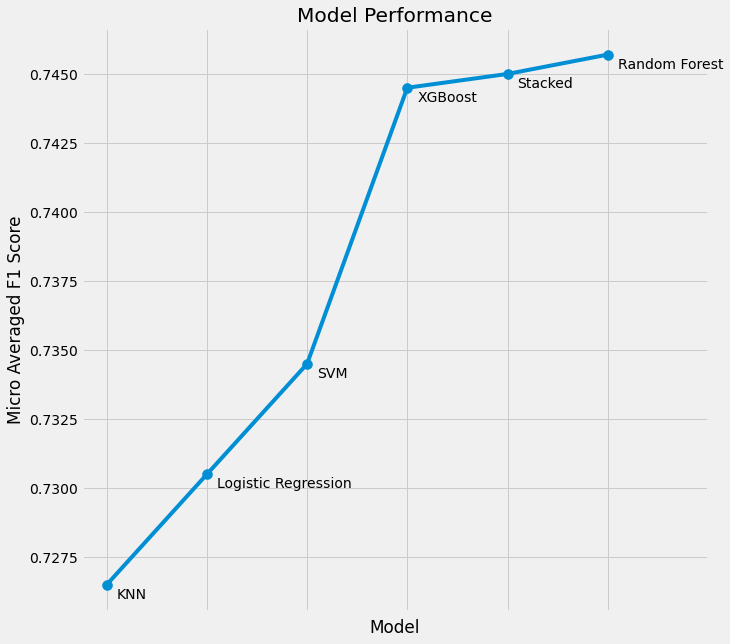

In [99]:
x = range(6)
fig, ax = plt.subplots(figsize=(10,10))
ax.plot(x, model_scores)
ax.scatter(x, model_scores, s=100)
ax.set_xlabel('Model')
ax.set_xticks(range(7))
ax.set_xticklabels(['' for x in range(7)])
ax.set_ylabel('Micro Averaged F1 Score')
ax.set_title('Model Performance')
for i, model in enumerate(model_names):
    ax.annotate(model, (x[i] + .1, model_scores[i] - .0005))